In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import pandas as pd
import seaborn as sns
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
warnings.filterwarnings("ignore", category=FutureWarning)

# Inicializando la sesión Spark
spark = SparkSession.builder.appName("AnalisisCompletoDeDatos").getOrCreate()

# Ruta de la carpeta con los archivos Parquet
ruta = "/Users/felipediegolobatodasilva/Documents/Git/despliegue_analytica/files_parquet/"

# Listar todos los archivos Parquet en la carpeta
archivos_parquet = [f"{ruta}{f}" for f in os.listdir(ruta) if f.endswith('.parquet')]

In [27]:
# Cargar el DataFrame en pysapark
df_base = spark.read.parquet('/Users/felipediegolobatodasilva/Desktop/git/despliegue_analytica/files_parquet/df_joined_cleaned_no_nulls.parquet')

# Diccionario para renombrar las columnas al español
nombres_columnas_espanol = {
    'order_id': 'id_pedido',
    'seller_id': 'id_vendedor',
    'product_id': 'id_producto',
    'customer_id': 'id_cliente',
    'order_status': 'estado_pedido',
    'order_purchase_timestamp': 'fecha_compra_pedido',
    'order_approved_at': 'fecha_aprobacion_pedido',
    'order_estimated_delivery_date': 'fecha_entrega_estimada',
    'order_item_id': 'id_item_pedido',
    'shipping_limit_date': 'fecha_limite_envio',
    'price': 'precio',
    'freight_value': 'valor_flete',
    'payment_sequential': 'secuencia_pago',
    'payment_type': 'tipo_pago',
    'payment_installments': 'cuotas_pago',
    'payment_value': 'valor_pago',
    'customer_unique_id': 'id_unico_cliente',
    'customer_zip_code_prefix': 'codigo_postal_cliente',
    'customer_city': 'ciudad_cliente',
    'customer_state': 'estado_cliente',
    'product_category_name': 'nombre_categoria_producto',
    'product_name_lenght': 'longitud_nombre_producto',
    'product_description_lenght': 'longitud_descripcion_producto',
    'product_photos_qty': 'cantidad_fotos_producto',
    'product_weight_g': 'peso_producto_g',
    'product_length_cm': 'largo_producto_cm',
    'product_height_cm': 'altura_producto_cm',
    'product_width_cm': 'ancho_producto_cm',
    'seller_zip_code_prefix': 'codigo_postal_vendedor',
    'seller_city': 'ciudad_vendedor',
    'seller_state': 'estado_vendedor'
}

# Renombrar las columnas en el DataFrame de PySpark
for old_name, new_name in nombres_columnas_espanol.items():
    df_base = df_base.withColumnRenamed(old_name, new_name)

# Mostrar las columnas renombradas y la cantidad de registros
print("Columnas de df_base_spark:", df_base.columns)
print("\nCantidad de registros de df_base_spark:", df_base.count())

Columnas de df_base_spark: ['id_pedido', 'id_vendedor', 'id_producto', 'id_cliente', 'estado_pedido', 'fecha_compra_pedido', 'fecha_aprobacion_pedido', 'fecha_entrega_estimada', 'id_item_pedido', 'fecha_limite_envio', 'precio', 'valor_flete', 'secuencia_pago', 'tipo_pago', 'cuotas_pago', 'valor_pago', 'id_unico_cliente', 'codigo_postal_cliente', 'ciudad_cliente', 'estado_cliente', 'nombre_categoria_producto', 'longitud_nombre_producto', 'longitud_descripcion_producto', 'cantidad_fotos_producto', 'peso_producto_g', 'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 'codigo_postal_vendedor', 'ciudad_vendedor', 'estado_vendedor']

Cantidad de registros de df_base_spark: 116583


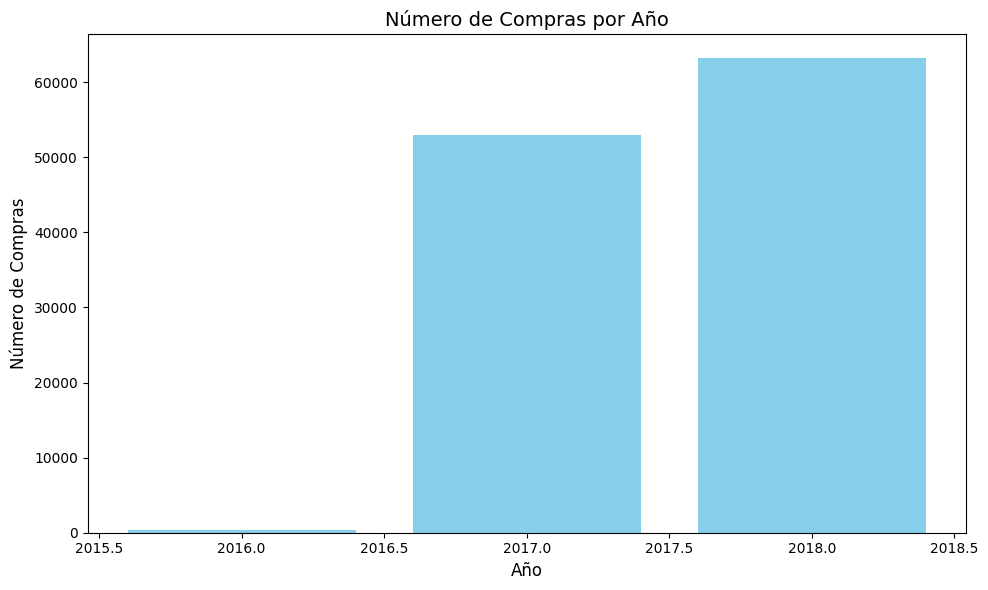

In [29]:
# Crear columna solo con la fecha
df_base = df_base.withColumn("fecha_pedido", to_date("fecha_compra_pedido"))

# Crear columna solo con la hora
df_base = df_base.withColumn("hora_compra_pedido", date_format("fecha_compra_pedido", "HH:mm:ss"))

# Extraer el año de la fecha de compra
df_base = df_base.withColumn("anio_compra_pedido", year("fecha_compra_pedido"))

# Agrupar por año y contar el número de ocurrencias
anio_counts = df_base.groupBy("anio_compra_pedido").count().orderBy("anio_compra_pedido")

# Convertir a pandas para visualización
anio_counts_pd = anio_counts.toPandas()

# Crear gráfico de barras con Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(anio_counts_pd['anio_compra_pedido'], anio_counts_pd['count'], color='skyblue')

# Añadir título y etiquetas
plt.title('Número de Compras por Año', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de Compras', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [30]:
#Creando el campo temporada
# Extraer el mes de la columna fecha_compra_pedido
df_base = df_base.withColumn("month", month("fecha_compra_pedido"))

# Función para asignar la temporada
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

# Registrar la función como una UDF (User Defined Function) para PySpark
assign_season_udf = udf(assign_season)

# Aplicar la función UDF para crear la columna de temporada
df_base = df_base.withColumn("temporada", assign_season_udf("month"))

# Mostrar el resultado
df_base.show()

+--------------------+--------------------+--------------------+--------------------+-------------+-------------------+-----------------------+----------------------+--------------+-------------------+------+-----------+--------------+-----------+-----------+----------+--------------------+---------------------+--------------------+--------------+-------------------------+------------------------+-----------------------------+-----------------------+---------------+-----------------+------------------+-----------------+----------------------+--------------------+---------------+------------+------------------+------------------+-----+---------+
|           id_pedido|         id_vendedor|         id_producto|          id_cliente|estado_pedido|fecha_compra_pedido|fecha_aprobacion_pedido|fecha_entrega_estimada|id_item_pedido| fecha_limite_envio|precio|valor_flete|secuencia_pago|  tipo_pago|cuotas_pago|valor_pago|    id_unico_cliente|codigo_postal_cliente|      ciudad_cliente|estado_client

In [31]:
# Filtrar el DataFrame para incluir solo registros de 2018 o posteriores
df_baseFinal = df_base.filter(df_base['anio_compra_pedido'] >= 2018)

# Seleccionar solo las columnas deseadas
columnas2 = ['id_pedido', 'id_vendedor', 'id_producto', 'id_cliente',
       'estado_pedido', 'fecha_pedido', 'hora_compra_pedido', 'fecha_aprobacion_pedido',
       'fecha_entrega_estimada', 'id_item_pedido', 'fecha_limite_envio',
       'precio', 'valor_flete', 'secuencia_pago', 'tipo_pago', 'cuotas_pago',
       'valor_pago', 'id_unico_cliente', 'codigo_postal_cliente',
       'ciudad_cliente', 'estado_cliente', 'nombre_categoria_producto',
       'longitud_nombre_producto', 'longitud_descripcion_producto',
       'cantidad_fotos_producto', 'peso_producto_g', 'largo_producto_cm',
       'altura_producto_cm', 'ancho_producto_cm', 'codigo_postal_vendedor',
       'ciudad_vendedor', 'estado_vendedor', 'temporada']

df_baseFinal = df_baseFinal.select(columnas2)

# Obtener el número de filas y columnas
num_rows = df_baseFinal.count()               # Número de filas
num_columns = len(df_baseFinal.columns)       # Número de columnas

# Mostrar el resultado
print(f"Shape: ({num_rows}, {num_columns})")

Shape: (63215, 33)


In [32]:
# Guardar el archivo final en formato Parquet
df_baseFinal.write.mode("overwrite").parquet("files_parquet/df_baseFinal.parquet")

# Unificando base final con geolocalización

In [33]:
df = pd.read_csv('/Users/felipediegolobatodasilva/Documents/teste/despliegue_analytica/files_csv/base_dash.csv')

df.count()

Unnamed: 0                       63215
id_pedido                        63215
id_vendedor                      63215
id_producto                      63215
id_cliente                       63215
estado_pedido                    63215
fecha_pedido                     63215
hora_compra_pedido               63215
fecha_aprobacion_pedido          63215
fecha_entrega_estimada           63215
id_item_pedido                   63215
fecha_limite_envio               63215
precio                           63215
valor_flete                      63215
secuencia_pago                   63215
tipo_pago                        63215
cuotas_pago                      63215
valor_pago                       63215
id_unico_cliente                 63215
codigo_postal_cliente            63215
ciudad_cliente                   63215
estado_cliente                   63215
nombre_categoria_producto        63215
longitud_nombre_producto         63215
longitud_descripcion_producto    63215
cantidad_fotos_producto  

In [40]:
import dash
from dash import dcc, html
import dash.dash_table as dash_table
from dash.dependencies import Input, Output
import pandas as pd
from datetime import timedelta
import plotly.express as px
from pyspark.sql import SparkSession

# Iniciar una sesión Spark para cargar los datos Parquet
spark = SparkSession.builder.appName("GeolocationIntegration").getOrCreate()

# Cargar la base original
df = pd.read_csv('/Users/felipediegolobatodasilva/Documents/teste/despliegue_analytica/files_csv/base_dash.csv')

# Cargar la base de geolocalización
geo = spark.read.parquet('/Users/felipediegolobatodasilva/Documents/teste/despliegue_analytica/files_parquet/geolocation_correios_coords').toPandas()

# Renombrar las columnas del dataframe geo para evitar conflictos durante el merge
geo = geo.rename(columns={'cep_prefix': 'codigo_postal_cliente'})

# Mostrar los tipos antes de la conversión
print("Tipos de datos antes de la conversión:")
print("df['codigo_postal_cliente']:", df['codigo_postal_cliente'].dtype)
print("geo['codigo_postal_cliente']:", geo['codigo_postal_cliente'].dtype)

# Convertir la columna 'codigo_postal_cliente' de geo a int
try:
    geo['codigo_postal_cliente'] = geo['codigo_postal_cliente'].astype(int)
except ValueError as e:
    print("Error al convertir 'codigo_postal_cliente' a int en geo:", e)

# Realizar el merge basado en el código postal
df = pd.merge(df, geo[['codigo_postal_cliente', 'lat', 'lon']], on='codigo_postal_cliente', how='left')

# Mostrar las primeras filas para verificar el resultado
print(df.head())

# Mostrar el tipo final de la columna 'codigo_postal_cliente'
print("Tipo final de la columna 'codigo_postal_cliente':", df['codigo_postal_cliente'].dtype)

# Guardar la base resultante como CSV
output_path = '/Users/felipediegolobatodasilva/Documents/despliegue_analytica/tablero/base_dash_final.csv'
df.to_csv(output_path, index=False)
print(f"Base guardada en: {output_path}")

Tipos de datos antes de la conversión:
df['codigo_postal_cliente']: int64
geo['codigo_postal_cliente']: object
   Unnamed: 0                         id_pedido  \
0           0  53cdb2fc8bc7dce0b6741e2150273451   
1           1  47770eb9100c2d0c44946d9cf07ec65d   
2           1  47770eb9100c2d0c44946d9cf07ec65d   
3           1  47770eb9100c2d0c44946d9cf07ec65d   
4           1  47770eb9100c2d0c44946d9cf07ec65d   

                        id_vendedor                       id_producto  \
0  289cdb325fb7e7f891c38608bf9e0962  595fac2a385ac33a80bd5114aec74eb8   
1  4869f7a5dfa277a7dca6462dcf3b52b2  aa4383b373c6aca5d8797843e5594415   
2  4869f7a5dfa277a7dca6462dcf3b52b2  aa4383b373c6aca5d8797843e5594415   
3  4869f7a5dfa277a7dca6462dcf3b52b2  aa4383b373c6aca5d8797843e5594415   
4  4869f7a5dfa277a7dca6462dcf3b52b2  aa4383b373c6aca5d8797843e5594415   

                         id_cliente estado_pedido fecha_pedido  \
0  b0830fb4747a6c6d20dea0b8c802d7ef     delivered   2018-07-24   
1  41ce2a54

In [37]:
df.count()

Unnamed: 0                       123014
id_pedido                        123014
id_vendedor                      123014
id_producto                      123014
id_cliente                       123014
estado_pedido                    123014
fecha_pedido                     123014
hora_compra_pedido               123014
fecha_aprobacion_pedido          123014
fecha_entrega_estimada           123014
id_item_pedido                   123014
fecha_limite_envio               123014
precio                           123014
valor_flete                      123014
secuencia_pago                   123014
tipo_pago                        123014
cuotas_pago                      123014
valor_pago                       123014
id_unico_cliente                 123014
codigo_postal_cliente            123014
ciudad_cliente                   123014
estado_cliente                   123014
nombre_categoria_producto        123014
longitud_nombre_producto         123014
longitud_descripcion_producto    123014
